In [1]:
import torch
import data
import tqdm
import models
import numpy as np
from torchvision.transforms import v2
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
EPOCHS = 500
BATCH_SIZE = 10
LR = 5e-7
NOISE_STD = 0.4

In [3]:
def transform(x):
    x = v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))(x)
    return x

def show_random_image(dataset, model, length):
    i = np.random.randint(low=0,high=length)
    LR, trueHR = dataset[i]
    t1 = torch.tensor(LR.view(1,1,64,64))
    t2 = model(t1.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(trueHR.numpy()[0]*255)
    return image1, image2, image3

In [4]:
dataset = data.LensingDataset('../dataset_2/','sparse')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.denoiser = models.Resnet_SISR(residual_depth=10, 
                                            in_channels=1, 
                                            maginfication=1, 
                                            num_magnifications=0, 
                                            latent_channel_count=64)
        self.denoiser.load_state_dict(torch.load('../trained_weights/Resnet_denoiser%d.pt'%(int(NOISE_STD*10))))
        for m in self.denoiser.modules():
            m.requires_grad_(False)
        self.SR = models.Resnet_SISR(residual_depth=10, 
                                    in_channels=1, 
                                    maginfication=2, 
                                    num_magnifications=1, 
                                    latent_channel_count=64)
    
    def forward(self, x):
        x = self.denoiser(x)
        x = self.SR(x)
        return x
    
    def set_train(self):
        self.SR.train()

    def set_eval(self):
        self.SR.eval()

In [6]:
model = Model().to(device)

loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=2,factor=0.1)

In [7]:
history = {'val_loss':[], 'loss':[]}
best_val_loss = np.inf
best_weights = None
for epoch in range(EPOCHS):
    losses = []
    model.set_train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, y) = (x.float().to(device), y.float().to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.set_eval()
    losses = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    # images.append((show_random_image(train_dataset, model, 900)))
    # scheduler.step(train_loss)

Training epoch 1: 100%|██████████| 27/27 [00:06<00:00,  4.19it/s]


Training at epoch 1/500: 0.006372212966973031 at LR=5e-07


Validation epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 1/500: 0.004426969525714715 at LR=5e-07


Training epoch 2: 100%|██████████| 27/27 [00:04<00:00,  5.92it/s]


Training at epoch 2/500: 0.005380842765724218 at LR=5e-07


Validation epoch 1: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 2/500: 0.004554098394388954 at LR=5e-07


Training epoch 3: 100%|██████████| 27/27 [00:04<00:00,  5.96it/s]


Training at epoch 3/500: 0.0048244859316144825 at LR=5e-07


Validation epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 3/500: 0.004503215740745266 at LR=5e-07


Training epoch 4: 100%|██████████| 27/27 [00:04<00:00,  5.95it/s]


Training at epoch 4/500: 0.004477335829977636 at LR=5e-07


Validation epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 4/500: 0.0043128610122948885 at LR=5e-07


Training epoch 5: 100%|██████████| 27/27 [00:04<00:00,  5.95it/s]


Training at epoch 5/500: 0.004263224942540681 at LR=5e-07


Validation epoch 4: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 5/500: 0.003995922859758139 at LR=5e-07


Training epoch 6: 100%|██████████| 27/27 [00:04<00:00,  5.96it/s]


Training at epoch 6/500: 0.0040813329612353335 at LR=5e-07


Validation epoch 5: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Validation at epoch 6/500: 0.0038552277255803347 at LR=5e-07


Training epoch 7: 100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Training at epoch 7/500: 0.003975982898501334 at LR=5e-07


Validation epoch 6: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 7/500: 0.0037744916044175625 at LR=5e-07


Training epoch 8: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 8/500: 0.003866915884255259 at LR=5e-07


Validation epoch 7: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 8/500: 0.003613288359095653 at LR=5e-07


Training epoch 9: 100%|██████████| 27/27 [00:04<00:00,  5.93it/s]


Training at epoch 9/500: 0.003807066931147818 at LR=5e-07


Validation epoch 8: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 9/500: 0.0035448245083292327 at LR=5e-07


Training epoch 10: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 10/500: 0.003743846715358948 at LR=5e-07


Validation epoch 9: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 10/500: 0.0034923681523650885 at LR=5e-07


Training epoch 11: 100%|██████████| 27/27 [00:04<00:00,  5.92it/s]


Training at epoch 11/500: 0.0036859085257337602 at LR=5e-07


Validation epoch 10: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 11/500: 0.0034450526194026074 at LR=5e-07


Training epoch 12: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 12/500: 0.003652180144045916 at LR=5e-07


Validation epoch 11: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 12/500: 0.0033954312093555927 at LR=5e-07


Training epoch 13: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 13/500: 0.003607932672215005 at LR=5e-07


Validation epoch 12: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 13/500: 0.0033737740013748407 at LR=5e-07


Training epoch 14: 100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Training at epoch 14/500: 0.0035856720448161163 at LR=5e-07


Validation epoch 13: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 14/500: 0.0033170314660916724 at LR=5e-07


Training epoch 15: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 15/500: 0.0035876420809438933 at LR=5e-07


Validation epoch 14: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 15/500: 0.0033326035675903163 at LR=5e-07


Training epoch 16: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 16/500: 0.0035505808062023586 at LR=5e-07


Validation epoch 15: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 16/500: 0.0033059074388196072 at LR=5e-07


Training epoch 17: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 17/500: 0.0035234653796241792 at LR=5e-07


Validation epoch 16: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 17/500: 0.0032754037529230118 at LR=5e-07


Training epoch 18: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 18/500: 0.003515693816114907 at LR=5e-07


Validation epoch 17: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 18/500: 0.0032664747753491006 at LR=5e-07


Training epoch 19: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 19/500: 0.003494684136024228 at LR=5e-07


Validation epoch 18: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 19/500: 0.0032172753320386014 at LR=5e-07


Training epoch 20: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 20/500: 0.0034743839210865123 at LR=5e-07


Validation epoch 19: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 20/500: 0.003219895763322711 at LR=5e-07


Training epoch 21: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 21/500: 0.0034659743455618067 at LR=5e-07


Validation epoch 20: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 21/500: 0.0031986020039767027 at LR=5e-07


Training epoch 22: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 22/500: 0.0034673275874444734 at LR=5e-07


Validation epoch 21: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 22/500: 0.0031862449444209537 at LR=5e-07


Training epoch 23: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 23/500: 0.003434915953591742 at LR=5e-07


Validation epoch 22: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 23/500: 0.003150103148072958 at LR=5e-07


Training epoch 24: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 24/500: 0.003440083707337854 at LR=5e-07


Validation epoch 23: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 24/500: 0.0031643067486584187 at LR=5e-07


Training epoch 25: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 25/500: 0.003426346000870345 at LR=5e-07


Validation epoch 24: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 25/500: 0.003132570612554749 at LR=5e-07


Training epoch 26: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 26/500: 0.0034288257248354733 at LR=5e-07


Validation epoch 25: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 26/500: 0.0031075989827513695 at LR=5e-07


Training epoch 27: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 27/500: 0.0033999242802598964 at LR=5e-07


Validation epoch 26: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 27/500: 0.0031513276044279337 at LR=5e-07


Training epoch 28: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 28/500: 0.003373675720973147 at LR=5e-07


Validation epoch 27: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 28/500: 0.0030601560914268098 at LR=5e-07


Training epoch 29: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 29/500: 0.0032494470684064757 at LR=5e-07


Validation epoch 28: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 29/500: 0.0030125326787432036 at LR=5e-07


Training epoch 30: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 30/500: 0.003116449815462585 at LR=5e-07


Validation epoch 29: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 30/500: 0.0028708460740745068 at LR=5e-07


Training epoch 31: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 31/500: 0.00305702551095574 at LR=5e-07


Validation epoch 30: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 31/500: 0.00274174214185526 at LR=5e-07


Training epoch 32: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 32/500: 0.0029503947330845725 at LR=5e-07


Validation epoch 31: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 32/500: 0.0026325297464306154 at LR=5e-07


Training epoch 33: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 33/500: 0.002847757828594358 at LR=5e-07


Validation epoch 32: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 33/500: 0.002482625306583941 at LR=5e-07


Training epoch 34: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 34/500: 0.0027443119367860534 at LR=5e-07


Validation epoch 33: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 34/500: 0.0024851999090363583 at LR=5e-07


Training epoch 35: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 35/500: 0.0027000656506667533 at LR=5e-07


Validation epoch 34: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 35/500: 0.002371421200223267 at LR=5e-07


Training epoch 36: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 36/500: 0.002651498405073114 at LR=5e-07


Validation epoch 35: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 36/500: 0.0023500648870443306 at LR=5e-07


Training epoch 37: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 37/500: 0.002652090590412694 at LR=5e-07


Validation epoch 36: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 37/500: 0.002350760313371817 at LR=5e-07


Training epoch 38: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 38/500: 0.002604915070588942 at LR=5e-07


Validation epoch 37: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 38/500: 0.002284158254042268 at LR=5e-07


Training epoch 39: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 39/500: 0.002597522848561682 at LR=5e-07


Validation epoch 38: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 39/500: 0.0023322467459365726 at LR=5e-07


Training epoch 40: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 40/500: 0.0025634458072966446 at LR=5e-07


Validation epoch 39: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Validation at epoch 40/500: 0.002286946284584701 at LR=5e-07


Training epoch 41: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 41/500: 0.0025540299247950315 at LR=5e-07


Validation epoch 40: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 41/500: 0.002240166572543482 at LR=5e-07


Training epoch 42: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 42/500: 0.0025356226855095614 at LR=5e-07


Validation epoch 41: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 42/500: 0.002276659399891893 at LR=5e-07


Training epoch 43: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 43/500: 0.002512937709171739 at LR=5e-07


Validation epoch 42: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 43/500: 0.00222465469657133 at LR=5e-07


Training epoch 44: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 44/500: 0.0024964625179698624 at LR=5e-07


Validation epoch 43: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 44/500: 0.002210833985979358 at LR=5e-07


Training epoch 45: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 45/500: 0.0024656409406344647 at LR=5e-07


Validation epoch 44: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 45/500: 0.0021748006887113056 at LR=5e-07


Training epoch 46: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 46/500: 0.0024736316753896296 at LR=5e-07


Validation epoch 45: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 46/500: 0.00217160873580724 at LR=5e-07


Training epoch 47: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 47/500: 0.0024549999075976236 at LR=5e-07


Validation epoch 46: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 47/500: 0.002119975940634807 at LR=5e-07


Training epoch 48: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 48/500: 0.0024462861388369842 at LR=5e-07


Validation epoch 47: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 48/500: 0.002127376191007594 at LR=5e-07


Training epoch 49: 100%|██████████| 27/27 [00:04<00:00,  5.81it/s]


Training at epoch 49/500: 0.0024386688924601507 at LR=5e-07


Validation epoch 48: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 49/500: 0.002085629850625992 at LR=5e-07


Training epoch 50: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 50/500: 0.002416881484721132 at LR=5e-07


Validation epoch 49: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 50/500: 0.002133809534522394 at LR=5e-07


Training epoch 51: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 51/500: 0.0024307778760514877 at LR=5e-07


Validation epoch 50: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 51/500: 0.002124035459322234 at LR=5e-07


Training epoch 52: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 52/500: 0.0023579326441028605 at LR=5e-07


Validation epoch 51: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 52/500: 0.0020769739833970866 at LR=5e-07


Training epoch 53: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 53/500: 0.0023608661851742202 at LR=5e-07


Validation epoch 52: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 53/500: 0.002096874794612328 at LR=5e-07


Training epoch 54: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 54/500: 0.002361158728254614 at LR=5e-07


Validation epoch 53: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 54/500: 0.0020340958144515753 at LR=5e-07


Training epoch 55: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 55/500: 0.0023335118441739017 at LR=5e-07


Validation epoch 54: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 55/500: 0.001980566264440616 at LR=5e-07


Training epoch 56: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 56/500: 0.0022983357775956392 at LR=5e-07


Validation epoch 55: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 56/500: 0.0019924313916514316 at LR=5e-07


Training epoch 57: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 57/500: 0.002319437158466489 at LR=5e-07


Validation epoch 56: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 57/500: 0.0019686471593255797 at LR=5e-07


Training epoch 58: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 58/500: 0.002300843980197829 at LR=5e-07


Validation epoch 57: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 58/500: 0.0019543290060634413 at LR=5e-07


Training epoch 59: 100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Training at epoch 59/500: 0.002274785910871018 at LR=5e-07


Validation epoch 58: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 59/500: 0.001926477571638922 at LR=5e-07


Training epoch 60: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 60/500: 0.0022567276071101703 at LR=5e-07


Validation epoch 59: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 60/500: 0.0019772839926493666 at LR=5e-07


Training epoch 61: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 61/500: 0.0022809470214674044 at LR=5e-07


Validation epoch 60: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 61/500: 0.0019567558774724603 at LR=5e-07


Training epoch 62: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 62/500: 0.002248134127714568 at LR=5e-07


Validation epoch 61: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 62/500: 0.0019365559952954452 at LR=5e-07


Training epoch 63: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 63/500: 0.002231059880513284 at LR=5e-07


Validation epoch 62: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 63/500: 0.001901016531822582 at LR=5e-07


Training epoch 64: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 64/500: 0.0022188482064477823 at LR=5e-07


Validation epoch 63: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 64/500: 0.001914088303844134 at LR=5e-07


Training epoch 65: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 65/500: 0.0022117673264195523 at LR=5e-07


Validation epoch 64: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 65/500: 0.0018664438199872773 at LR=5e-07


Training epoch 66: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 66/500: 0.002194484784181609 at LR=5e-07


Validation epoch 65: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 66/500: 0.0018566861981526017 at LR=5e-07


Training epoch 67: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 67/500: 0.0021956377723081795 at LR=5e-07


Validation epoch 66: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 67/500: 0.0018380627152509987 at LR=5e-07


Training epoch 68: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 68/500: 0.002164999816428732 at LR=5e-07


Validation epoch 67: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 68/500: 0.0018790606409311295 at LR=5e-07


Training epoch 69: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 69/500: 0.0021357863529205875 at LR=5e-07


Validation epoch 68: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 69/500: 0.0018272635837395985 at LR=5e-07


Training epoch 70: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 70/500: 0.0021645376648477934 at LR=5e-07


Validation epoch 69: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 70/500: 0.0018242414031798642 at LR=5e-07


Training epoch 71: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 71/500: 0.002135762218299701 at LR=5e-07


Validation epoch 70: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 71/500: 0.0018303704564459622 at LR=5e-07


Training epoch 72: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 72/500: 0.002116490925093078 at LR=5e-07


Validation epoch 71: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 72/500: 0.0018235613048697512 at LR=5e-07


Training epoch 73: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 73/500: 0.0020994915695929967 at LR=5e-07


Validation epoch 72: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 73/500: 0.0018213279933358233 at LR=5e-07


Training epoch 74: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 74/500: 0.002100160614915054 at LR=5e-07


Validation epoch 73: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 74/500: 0.0018443508306518197 at LR=5e-07


Training epoch 75: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 75/500: 0.0020703419146162493 at LR=5e-07


Validation epoch 74: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 75/500: 0.0017855257804815967 at LR=5e-07


Training epoch 76: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 76/500: 0.0020782917617233813 at LR=5e-07


Validation epoch 75: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 76/500: 0.0017727735685184598 at LR=5e-07


Training epoch 77: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 77/500: 0.002050782883695016 at LR=5e-07


Validation epoch 76: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 77/500: 0.00172777462285012 at LR=5e-07


Training epoch 78: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 78/500: 0.002063368020268778 at LR=5e-07


Validation epoch 77: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 78/500: 0.0017473721333468954 at LR=5e-07


Training epoch 79: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 79/500: 0.0020462824053269018 at LR=5e-07


Validation epoch 78: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 79/500: 0.0017492660554125905 at LR=5e-07


Training epoch 80: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 80/500: 0.002041718329699641 at LR=5e-07


Validation epoch 79: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 80/500: 0.0017670719341064494 at LR=5e-07


Training epoch 81: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 81/500: 0.002019686367862892 at LR=5e-07


Validation epoch 80: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 81/500: 0.001744053481767575 at LR=5e-07


Training epoch 82: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 82/500: 0.0020020344484321497 at LR=5e-07


Validation epoch 81: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 82/500: 0.001667082814189295 at LR=5e-07


Training epoch 83: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 83/500: 0.0019946300157311337 at LR=5e-07


Validation epoch 82: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 83/500: 0.0017718052258715034 at LR=5e-07


Training epoch 84: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 84/500: 0.0019993677377459352 at LR=5e-07


Validation epoch 83: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 84/500: 0.0017021521537875135 at LR=5e-07


Training epoch 85: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 85/500: 0.001975229320426782 at LR=5e-07


Validation epoch 84: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 85/500: 0.0017141373828053474 at LR=5e-07


Training epoch 86: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 86/500: 0.0019710084845967315 at LR=5e-07


Validation epoch 85: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 86/500: 0.0016314092402656872 at LR=5e-07


Training epoch 87: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 87/500: 0.0019828286776491615 at LR=5e-07


Validation epoch 86: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 87/500: 0.0017159831477329135 at LR=5e-07


Training epoch 88: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 88/500: 0.0019524269607952898 at LR=5e-07


Validation epoch 87: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 88/500: 0.001686817694765826 at LR=5e-07


Training epoch 89: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 89/500: 0.0019913282529968354 at LR=5e-07


Validation epoch 88: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 89/500: 0.0016456422357199092 at LR=5e-07


Training epoch 90: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 90/500: 0.0019501642134316542 at LR=5e-07


Validation epoch 89: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 90/500: 0.0016802219906821847 at LR=5e-07


Training epoch 91: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 91/500: 0.0019592413467493046 at LR=5e-07


Validation epoch 90: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 91/500: 0.0016361913876608014 at LR=5e-07


Training epoch 92: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 92/500: 0.0019144965227934773 at LR=5e-07


Validation epoch 91: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 92/500: 0.0015891719182642798 at LR=5e-07


Training epoch 93: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 93/500: 0.0019089181484930494 at LR=5e-07


Validation epoch 92: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 93/500: 0.0016131647474442918 at LR=5e-07


Training epoch 94: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 94/500: 0.0019275416529530452 at LR=5e-07


Validation epoch 93: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 94/500: 0.0016219337315609057 at LR=5e-07


Training epoch 95: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 95/500: 0.0019237149304158433 at LR=5e-07


Validation epoch 94: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 95/500: 0.0016499906390284498 at LR=5e-07


Training epoch 96: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 96/500: 0.0018900678863886882 at LR=5e-07


Validation epoch 95: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 96/500: 0.0016085705137811601 at LR=5e-07


Training epoch 97: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 97/500: 0.0018905497444966048 at LR=5e-07


Validation epoch 96: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 97/500: 0.001612298539839685 at LR=5e-07


Training epoch 98: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 98/500: 0.0019032187496863858 at LR=5e-07


Validation epoch 97: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 98/500: 0.0015410257037729025 at LR=5e-07


Training epoch 99: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 99/500: 0.0018706080542566876 at LR=5e-07


Validation epoch 98: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 99/500: 0.0016250355790058772 at LR=5e-07


Training epoch 100: 100%|██████████| 27/27 [00:04<00:00,  5.81it/s]


Training at epoch 100/500: 0.001884905326059433 at LR=5e-07


Validation epoch 99: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 100/500: 0.0015674173288668196 at LR=5e-07


Training epoch 101: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 101/500: 0.0018749820516893157 at LR=5e-07


Validation epoch 100: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 101/500: 0.001556288218125701 at LR=5e-07


Training epoch 102: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 102/500: 0.0018221092888981933 at LR=5e-07


Validation epoch 101: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 102/500: 0.0015069546255593498 at LR=5e-07


Training epoch 103: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 103/500: 0.0018229539079281192 at LR=5e-07


Validation epoch 102: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 103/500: 0.0015218027207689981 at LR=5e-07


Training epoch 104: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 104/500: 0.0018262356342920274 at LR=5e-07


Validation epoch 103: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 104/500: 0.0015524805057793856 at LR=5e-07


Training epoch 105: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 105/500: 0.0018293453419270616 at LR=5e-07


Validation epoch 104: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 105/500: 0.001561339614757647 at LR=5e-07


Training epoch 106: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 106/500: 0.0018369346055098707 at LR=5e-07


Validation epoch 105: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 106/500: 0.0016138820404497285 at LR=5e-07


Training epoch 107: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 107/500: 0.0017948956789310883 at LR=5e-07


Validation epoch 106: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 107/500: 0.00155111204367131 at LR=5e-07


Training epoch 108: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 108/500: 0.0018216262386111474 at LR=5e-07


Validation epoch 107: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 108/500: 0.001532980512517194 at LR=5e-07


Training epoch 109: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 109/500: 0.0018249292926931823 at LR=5e-07


Validation epoch 108: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 109/500: 0.0015568166660765808 at LR=5e-07


Training epoch 110: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 110/500: 0.0017980766823273843 at LR=5e-07


Validation epoch 109: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 110/500: 0.0015655072638764977 at LR=5e-07


Training epoch 111: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 111/500: 0.0018129951268848446 at LR=5e-07


Validation epoch 110: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 111/500: 0.0015002687190038462 at LR=5e-07


Training epoch 112: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 112/500: 0.0017769050340306152 at LR=5e-07


Validation epoch 111: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 112/500: 0.0015229789229730766 at LR=5e-07


Training epoch 113: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 113/500: 0.0017688851523282075 at LR=5e-07


Validation epoch 112: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 113/500: 0.0015028578539689381 at LR=5e-07


Training epoch 114: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 114/500: 0.0017781950537701723 at LR=5e-07


Validation epoch 113: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 114/500: 0.00149763321193556 at LR=5e-07


Training epoch 115: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 115/500: 0.0017947469540457758 at LR=5e-07


Validation epoch 114: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 115/500: 0.0014540765356893341 at LR=5e-07


Training epoch 116: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 116/500: 0.0017841125135654929 at LR=5e-07


Validation epoch 115: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 116/500: 0.0014614643490252395 at LR=5e-07


Training epoch 117: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 117/500: 0.0017492832654776673 at LR=5e-07


Validation epoch 116: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 117/500: 0.001492356532253325 at LR=5e-07


Training epoch 118: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 118/500: 0.0017215473064290429 at LR=5e-07


Validation epoch 117: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 118/500: 0.001524409434447686 at LR=5e-07


Training epoch 119: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 119/500: 0.00174807985658171 at LR=5e-07


Validation epoch 118: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 119/500: 0.0014738494258684416 at LR=5e-07


Training epoch 120: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 120/500: 0.0017223976987965958 at LR=5e-07


Validation epoch 119: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 120/500: 0.0014768314819472532 at LR=5e-07


Training epoch 121: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 121/500: 0.0017202407708046613 at LR=5e-07


Validation epoch 120: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 121/500: 0.0014369727189963062 at LR=5e-07


Training epoch 122: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 122/500: 0.0017525325141226251 at LR=5e-07


Validation epoch 121: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 122/500: 0.0014573531419349213 at LR=5e-07


Training epoch 123: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 123/500: 0.0017100505323873626 at LR=5e-07


Validation epoch 122: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 123/500: 0.001463081610078613 at LR=5e-07


Training epoch 124: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 124/500: 0.0017093558304218783 at LR=5e-07


Validation epoch 123: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 124/500: 0.001436838375714918 at LR=5e-07


Training epoch 125: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 125/500: 0.0017379102322997318 at LR=5e-07


Validation epoch 124: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 125/500: 0.0014746049030994375 at LR=5e-07


Training epoch 126: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 126/500: 0.0017031950345780286 at LR=5e-07


Validation epoch 125: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 126/500: 0.001478412130381912 at LR=5e-07


Training epoch 127: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 127/500: 0.0016780871061470221 at LR=5e-07


Validation epoch 126: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 127/500: 0.0014101708075031638 at LR=5e-07


Training epoch 128: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 128/500: 0.0017065879440417997 at LR=5e-07


Validation epoch 127: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 128/500: 0.0014072449412196875 at LR=5e-07


Training epoch 129: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 129/500: 0.0017187324249082142 at LR=5e-07


Validation epoch 128: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 129/500: 0.0013758406081857781 at LR=5e-07


Training epoch 130: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 130/500: 0.0017021611975333482 at LR=5e-07


Validation epoch 129: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 130/500: 0.0014245871764918168 at LR=5e-07


Training epoch 131: 100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Training at epoch 131/500: 0.001652139525739821 at LR=5e-07


Validation epoch 130: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 131/500: 0.0014088398699338238 at LR=5e-07


Training epoch 132: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 132/500: 0.0016843372356594988 at LR=5e-07


Validation epoch 131: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 132/500: 0.0014252867355632286 at LR=5e-07


Training epoch 133: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 133/500: 0.0016661001287435215 at LR=5e-07


Validation epoch 132: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 133/500: 0.0014190115810682376 at LR=5e-07


Training epoch 134: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 134/500: 0.0016459479488225447 at LR=5e-07


Validation epoch 133: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 134/500: 0.001361745681303243 at LR=5e-07


Training epoch 135: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 135/500: 0.0016586221301824683 at LR=5e-07


Validation epoch 134: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 135/500: 0.0013304781556750338 at LR=5e-07


Training epoch 136: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 136/500: 0.0016612233076658514 at LR=5e-07


Validation epoch 135: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 136/500: 0.0014411709271371365 at LR=5e-07


Training epoch 137: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 137/500: 0.001652608653616712 at LR=5e-07


Validation epoch 136: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 137/500: 0.001406211774641027 at LR=5e-07


Training epoch 138: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 138/500: 0.0016498285802771097 at LR=5e-07


Validation epoch 137: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 138/500: 0.001373159388701121 at LR=5e-07


Training epoch 139: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 139/500: 0.0016408302342622643 at LR=5e-07


Validation epoch 138: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 139/500: 0.0013779037011166413 at LR=5e-07


Training epoch 140: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 140/500: 0.001647580632750221 at LR=5e-07


Validation epoch 139: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 140/500: 0.0013486075913533568 at LR=5e-07


Training epoch 141: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 141/500: 0.001650870572861836 at LR=5e-07


Validation epoch 140: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 141/500: 0.0013946931770381827 at LR=5e-07


Training epoch 142: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 142/500: 0.0016725910331674473 at LR=5e-07


Validation epoch 141: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 142/500: 0.0013145122987528641 at LR=5e-07


Training epoch 143: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 143/500: 0.0016395202191132638 at LR=5e-07


Validation epoch 142: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 143/500: 0.00133609944411243 at LR=5e-07


Training epoch 144: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 144/500: 0.0016435892967921165 at LR=5e-07


Validation epoch 143: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 144/500: 0.0013594887568615377 at LR=5e-07


Training epoch 145: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 145/500: 0.001602081306002758 at LR=5e-07


Validation epoch 144: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 145/500: 0.0013408114900812507 at LR=5e-07


Training epoch 146: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 146/500: 0.0016145033253080867 at LR=5e-07


Validation epoch 145: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 146/500: 0.0012966249293337266 at LR=5e-07


Training epoch 147: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 147/500: 0.0016102559381613024 at LR=5e-07


Validation epoch 146: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 147/500: 0.0013795933530976374 at LR=5e-07


Training epoch 148: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 148/500: 0.0016196181682904284 at LR=5e-07


Validation epoch 147: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 148/500: 0.0013565004337579012 at LR=5e-07


Training epoch 149: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 149/500: 0.0016311935356093778 at LR=5e-07


Validation epoch 148: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 149/500: 0.001268285404269894 at LR=5e-07


Training epoch 150: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 150/500: 0.0016198043896885658 at LR=5e-07


Validation epoch 149: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 150/500: 0.0013843823495941858 at LR=5e-07


Training epoch 151: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 151/500: 0.0016053902045651167 at LR=5e-07


Validation epoch 150: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 151/500: 0.0013367496236848335 at LR=5e-07


Training epoch 152: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 152/500: 0.001597949047141743 at LR=5e-07


Validation epoch 151: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 152/500: 0.001274780137464404 at LR=5e-07


Training epoch 153: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 153/500: 0.001593168488600188 at LR=5e-07


Validation epoch 152: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 153/500: 0.0013053491323565443 at LR=5e-07


Training epoch 154: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 154/500: 0.0015917702608189924 at LR=5e-07


Validation epoch 153: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 154/500: 0.0012420635321177542 at LR=5e-07


Training epoch 155: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 155/500: 0.0015899990814634496 at LR=5e-07


Validation epoch 154: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 155/500: 0.0012761821077826123 at LR=5e-07


Training epoch 156: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 156/500: 0.001582448269430272 at LR=5e-07


Validation epoch 155: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 156/500: 0.0012968877951304119 at LR=5e-07


Training epoch 157: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 157/500: 0.0015931028066444451 at LR=5e-07


Validation epoch 156: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 157/500: 0.0013657394447363913 at LR=5e-07


Training epoch 158: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 158/500: 0.0015807072287080464 at LR=5e-07


Validation epoch 157: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 158/500: 0.0012772380529592435 at LR=5e-07


Training epoch 159: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 159/500: 0.0015839662217466092 at LR=5e-07


Validation epoch 158: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 159/500: 0.0013167296225825946 at LR=5e-07


Training epoch 160: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 160/500: 0.00156669476914599 at LR=5e-07


Validation epoch 159: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 160/500: 0.0012767349059383075 at LR=5e-07


Training epoch 161: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 161/500: 0.0015885025625013644 at LR=5e-07


Validation epoch 160: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 161/500: 0.0012631639062116544 at LR=5e-07


Training epoch 162: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 162/500: 0.0015893208889152717 at LR=5e-07


Validation epoch 161: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 162/500: 0.0012602669497330983 at LR=5e-07


Training epoch 163: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 163/500: 0.0015970656704330057 at LR=5e-07


Validation epoch 162: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 163/500: 0.0012633976293727756 at LR=5e-07


Training epoch 164: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 164/500: 0.00156070814140279 at LR=5e-07


Validation epoch 163: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 164/500: 0.0012543480067203443 at LR=5e-07


Training epoch 165: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 165/500: 0.001573454043224316 at LR=5e-07


Validation epoch 164: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 165/500: 0.001245355000719428 at LR=5e-07


Training epoch 166: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 166/500: 0.001536724582331738 at LR=5e-07


Validation epoch 165: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 166/500: 0.001277510814058284 at LR=5e-07


Training epoch 167: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 167/500: 0.001584335305745265 at LR=5e-07


Validation epoch 166: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 167/500: 0.0012851297312105696 at LR=5e-07


Training epoch 168: 100%|██████████| 27/27 [00:05<00:00,  5.37it/s]


Training at epoch 168/500: 0.0015529414996746237 at LR=5e-07


Validation epoch 167: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 168/500: 0.0012469170809102554 at LR=5e-07


Training epoch 169: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 169/500: 0.0015391426040204587 at LR=5e-07


Validation epoch 168: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 169/500: 0.0012749054973634581 at LR=5e-07


Training epoch 170: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 170/500: 0.001552581338694802 at LR=5e-07


Validation epoch 169: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 170/500: 0.0013500703886772196 at LR=5e-07


Training epoch 171: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 171/500: 0.0015301969025232312 at LR=5e-07


Validation epoch 170: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 171/500: 0.0012297820067033172 at LR=5e-07


Training epoch 172: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 172/500: 0.0015252719641904587 at LR=5e-07


Validation epoch 171: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 172/500: 0.0012506135390140116 at LR=5e-07


Training epoch 173: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 173/500: 0.0015606049780250975 at LR=5e-07


Validation epoch 172: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 173/500: 0.0012400664466743667 at LR=5e-07


Training epoch 174: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 174/500: 0.0015302136393815832 at LR=5e-07


Validation epoch 173: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 174/500: 0.0012190893176011741 at LR=5e-07


Training epoch 175: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 175/500: 0.0015214471495710313 at LR=5e-07


Validation epoch 174: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 175/500: 0.0012419076131967206 at LR=5e-07


Training epoch 176: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 176/500: 0.0015385803546653027 at LR=5e-07


Validation epoch 175: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 176/500: 0.0012600179373597105 at LR=5e-07


Training epoch 177: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 177/500: 0.0015176932749993823 at LR=5e-07


Validation epoch 176: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 177/500: 0.0012702993893374999 at LR=5e-07


Training epoch 178: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 178/500: 0.0015285731922766125 at LR=5e-07


Validation epoch 177: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 178/500: 0.001267745081956188 at LR=5e-07


Training epoch 179: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 179/500: 0.0014873142267956777 at LR=5e-07


Validation epoch 178: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 179/500: 0.001196976751089096 at LR=5e-07


Training epoch 180: 100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Training at epoch 180/500: 0.00153476385080635 at LR=5e-07


Validation epoch 179: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 180/500: 0.0012211115487540762 at LR=5e-07


Training epoch 181: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 181/500: 0.0014976503616371364 at LR=5e-07


Validation epoch 180: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Validation at epoch 181/500: 0.001257272999888907 at LR=5e-07


Training epoch 182: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 182/500: 0.001516683956314982 at LR=5e-07


Validation epoch 181: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 182/500: 0.0012058756353023152 at LR=5e-07


Training epoch 183: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 183/500: 0.001510500981196485 at LR=5e-07


Validation epoch 182: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 183/500: 0.001251357898581773 at LR=5e-07


Training epoch 184: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 184/500: 0.0015016693354549784 at LR=5e-07


Validation epoch 183: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 184/500: 0.0012125983679046233 at LR=5e-07


Training epoch 185: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 185/500: 0.0014932387577438796 at LR=5e-07


Validation epoch 184: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 185/500: 0.0011798696941696107 at LR=5e-07


Training epoch 186: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 186/500: 0.0015093237161636353 at LR=5e-07


Validation epoch 185: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 186/500: 0.0013049149032061298 at LR=5e-07


Training epoch 187: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 187/500: 0.001492832088842988 at LR=5e-07


Validation epoch 186: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 187/500: 0.001222093259760489 at LR=5e-07


Training epoch 188: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 188/500: 0.0015049000525053729 at LR=5e-07


Validation epoch 187: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 188/500: 0.0012264987841869395 at LR=5e-07


Training epoch 189: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 189/500: 0.0015008265294858979 at LR=5e-07


Validation epoch 188: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 189/500: 0.0012316990178078413 at LR=5e-07


Training epoch 190: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 190/500: 0.001482280529604328 at LR=5e-07


Validation epoch 189: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 190/500: 0.0012803529389202595 at LR=5e-07


Training epoch 191: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 191/500: 0.0014978324147200005 at LR=5e-07


Validation epoch 190: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 191/500: 0.0012294926564209163 at LR=5e-07


Training epoch 192: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 192/500: 0.0014889422670455166 at LR=5e-07


Validation epoch 191: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 192/500: 0.001195619018593182 at LR=5e-07


Training epoch 193: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 193/500: 0.001487061673456251 at LR=5e-07


Validation epoch 192: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 193/500: 0.0012342177603083353 at LR=5e-07


Training epoch 194: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 194/500: 0.0015016134431654656 at LR=5e-07


Validation epoch 193: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 194/500: 0.0011861581588163972 at LR=5e-07


Training epoch 195: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 195/500: 0.0015149394425356553 at LR=5e-07


Validation epoch 194: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 195/500: 0.0011980862473137677 at LR=5e-07


Training epoch 196: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 196/500: 0.0014815786465381582 at LR=5e-07


Validation epoch 195: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 196/500: 0.0011819747742265463 at LR=5e-07


Training epoch 197: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 197/500: 0.0014908677635334985 at LR=5e-07


Validation epoch 196: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 197/500: 0.0012444811097035806 at LR=5e-07


Training epoch 198: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 198/500: 0.0014816292462422065 at LR=5e-07


Validation epoch 197: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 198/500: 0.0012194850132800639 at LR=5e-07


Training epoch 199: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 199/500: 0.0014843555852874285 at LR=5e-07


Validation epoch 198: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 199/500: 0.0012399985377366345 at LR=5e-07


Training epoch 200: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 200/500: 0.0014711596638705858 at LR=5e-07


Validation epoch 199: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 200/500: 0.0011717022280208766 at LR=5e-07


Training epoch 201: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 201/500: 0.0014511685952095798 at LR=5e-07


Validation epoch 200: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 201/500: 0.001199271238874644 at LR=5e-07


Training epoch 202: 100%|██████████| 27/27 [00:04<00:00,  5.78it/s]


Training at epoch 202/500: 0.0014557506494586253 at LR=5e-07


Validation epoch 201: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 202/500: 0.0011957470754471917 at LR=5e-07


Training epoch 203: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 203/500: 0.0014447932534730407 at LR=5e-07


Validation epoch 202: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 203/500: 0.0012595876081225772 at LR=5e-07


Training epoch 204: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 204/500: 0.0014337718527746835 at LR=5e-07


Validation epoch 203: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 204/500: 0.0012331245234236121 at LR=5e-07


Training epoch 205: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 205/500: 0.0014854836432884138 at LR=5e-07


Validation epoch 204: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 205/500: 0.0012569262568528454 at LR=5e-07


Training epoch 206: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 206/500: 0.0014614953499942742 at LR=5e-07


Validation epoch 205: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 206/500: 0.0011751046016191442 at LR=5e-07


Training epoch 207: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 207/500: 0.0014552866664922072 at LR=5e-07


Validation epoch 206: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 207/500: 0.00120571133447811 at LR=5e-07


Training epoch 208: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 208/500: 0.0014620087437193703 at LR=5e-07


Validation epoch 207: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 208/500: 0.001212715869769454 at LR=5e-07


Training epoch 209: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 209/500: 0.0014315170421334053 at LR=5e-07


Validation epoch 208: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 209/500: 0.0011873612723623712 at LR=5e-07


Training epoch 210: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 210/500: 0.0014492008722973642 at LR=5e-07


Validation epoch 209: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 210/500: 0.0011642135214060545 at LR=5e-07


Training epoch 211: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 211/500: 0.0014371402805274421 at LR=5e-07


Validation epoch 210: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 211/500: 0.0011264677353513737 at LR=5e-07


Training epoch 212: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 212/500: 0.0014335032686142734 at LR=5e-07


Validation epoch 211: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 212/500: 0.0011667978833429515 at LR=5e-07


Training epoch 213: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 213/500: 0.0014446619078861895 at LR=5e-07


Validation epoch 212: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 213/500: 0.001235153079809 at LR=5e-07


Training epoch 214: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 214/500: 0.0014593951960301234 at LR=5e-07


Validation epoch 213: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 214/500: 0.001131751264135043 at LR=5e-07


Training epoch 215: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 215/500: 0.0014485607173776738 at LR=5e-07


Validation epoch 214: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 215/500: 0.0011101561637284856 at LR=5e-07


Training epoch 216: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 216/500: 0.001425536135987689 at LR=5e-07


Validation epoch 215: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 216/500: 0.0011233478241289656 at LR=5e-07


Training epoch 217: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 217/500: 0.0014042401625947267 at LR=5e-07


Validation epoch 216: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 217/500: 0.0011056089036477108 at LR=5e-07


Training epoch 218: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 218/500: 0.0014322268522206556 at LR=5e-07


Validation epoch 217: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 218/500: 0.001161039515864104 at LR=5e-07


Training epoch 219: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 219/500: 0.0014435582863235915 at LR=5e-07


Validation epoch 218: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 219/500: 0.0010995482249806325 at LR=5e-07


Training epoch 220: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 220/500: 0.001430801226955804 at LR=5e-07


Validation epoch 219: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 220/500: 0.001183065411169082 at LR=5e-07


Training epoch 221: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 221/500: 0.0014260967684633754 at LR=5e-07


Validation epoch 220: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 221/500: 0.0011477327401128907 at LR=5e-07


Training epoch 222: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 222/500: 0.0014284057866057588 at LR=5e-07


Validation epoch 221: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 222/500: 0.0011490854861525197 at LR=5e-07


Training epoch 223: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 223/500: 0.0014199332217685878 at LR=5e-07


Validation epoch 222: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 223/500: 0.0011162709755202134 at LR=5e-07


Training epoch 224: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 224/500: 0.0014553361516273409 at LR=5e-07


Validation epoch 223: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 224/500: 0.0011203642546509702 at LR=5e-07


Training epoch 225: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 225/500: 0.0014197332590507965 at LR=5e-07


Validation epoch 224: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 225/500: 0.0011553423828445375 at LR=5e-07


Training epoch 226: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 226/500: 0.0014024969574098509 at LR=5e-07


Validation epoch 225: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 226/500: 0.0011622449577165146 at LR=5e-07


Training epoch 227: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 227/500: 0.0014156205655092857 at LR=5e-07


Validation epoch 226: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 227/500: 0.0011445519242746134 at LR=5e-07


Training epoch 228: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 228/500: 0.0013982907640402791 at LR=5e-07


Validation epoch 227: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 228/500: 0.0010887352594484885 at LR=5e-07


Training epoch 229: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 229/500: 0.0014046996118311115 at LR=5e-07


Validation epoch 228: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 229/500: 0.0011318409039328496 at LR=5e-07


Training epoch 230: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 230/500: 0.001422951457142416 at LR=5e-07


Validation epoch 229: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 230/500: 0.0010930615244433284 at LR=5e-07


Training epoch 231: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 231/500: 0.0013951933339100193 at LR=5e-07


Validation epoch 230: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 231/500: 0.001173425718055417 at LR=5e-07


Training epoch 232: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 232/500: 0.001398870193278762 at LR=5e-07


Validation epoch 231: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 232/500: 0.0011726115092945595 at LR=5e-07


Training epoch 233: 100%|██████████| 27/27 [00:04<00:00,  5.78it/s]


Training at epoch 233/500: 0.0014262905547015921 at LR=5e-07


Validation epoch 232: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 233/500: 0.001147132347493122 at LR=5e-07


Training epoch 234: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 234/500: 0.001406840226587115 at LR=5e-07


Validation epoch 233: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 234/500: 0.0011313870588007073 at LR=5e-07


Training epoch 235: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 235/500: 0.0014277002041193623 at LR=5e-07


Validation epoch 234: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 235/500: 0.0010716740313606958 at LR=5e-07


Training epoch 236: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 236/500: 0.0014219197942616625 at LR=5e-07


Validation epoch 235: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 236/500: 0.0011667267923864226 at LR=5e-07


Training epoch 237: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 237/500: 0.0014187697670422494 at LR=5e-07


Validation epoch 236: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 237/500: 0.0011579745914787054 at LR=5e-07


Training epoch 238: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 238/500: 0.0014328484992600149 at LR=5e-07


Validation epoch 237: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 238/500: 0.001103351319519182 at LR=5e-07


Training epoch 239: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 239/500: 0.001390345927103664 at LR=5e-07


Validation epoch 238: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 239/500: 0.001109674631152302 at LR=5e-07


Training epoch 240: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 240/500: 0.001398534878346793 at LR=5e-07


Validation epoch 239: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 240/500: 0.001093029141581307 at LR=5e-07


Training epoch 241: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 241/500: 0.0013948060028875868 at LR=5e-07


Validation epoch 240: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 241/500: 0.0010598941589705646 at LR=5e-07


Training epoch 242: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 242/500: 0.001384614483901748 at LR=5e-07


Validation epoch 241: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 242/500: 0.0011295641694838803 at LR=5e-07


Training epoch 243: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 243/500: 0.0013843177714281613 at LR=5e-07


Validation epoch 242: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 243/500: 0.0011471553201166291 at LR=5e-07


Training epoch 244: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 244/500: 0.0014087025321916575 at LR=5e-07


Validation epoch 243: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 244/500: 0.0011384196501846116 at LR=5e-07


Training epoch 245: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 245/500: 0.00138493005781331 at LR=5e-07


Validation epoch 244: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 245/500: 0.0010495126286211114 at LR=5e-07


Training epoch 246: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 246/500: 0.001402308774197957 at LR=5e-07


Validation epoch 245: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 246/500: 0.0011289285030215979 at LR=5e-07


Training epoch 247: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 247/500: 0.0013975845800747197 at LR=5e-07


Validation epoch 246: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 247/500: 0.0010924900998361409 at LR=5e-07


Training epoch 248: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 248/500: 0.001390206160808534 at LR=5e-07


Validation epoch 247: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 248/500: 0.0011000076192431152 at LR=5e-07


Training epoch 249: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 249/500: 0.0013814054589063205 at LR=5e-07


Validation epoch 248: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 249/500: 0.0011577222224635382 at LR=5e-07


Training epoch 250: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 250/500: 0.0013805728047844713 at LR=5e-07


Validation epoch 249: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 250/500: 0.0010885754406141739 at LR=5e-07


Training epoch 251: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 251/500: 0.0013789246915149743 at LR=5e-07


Validation epoch 250: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 251/500: 0.0011626673319066565 at LR=5e-07


Training epoch 252: 100%|██████████| 27/27 [00:04<00:00,  5.80it/s]


Training at epoch 252/500: 0.0013956804975384363 at LR=5e-07


Validation epoch 251: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 252/500: 0.001080788051088651 at LR=5e-07


Training epoch 253: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 253/500: 0.0013861043046711496 at LR=5e-07


Validation epoch 252: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 253/500: 0.0010595708930244048 at LR=5e-07


Training epoch 254: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 254/500: 0.0013730670993768231 at LR=5e-07


Validation epoch 253: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 254/500: 0.0010613754663305979 at LR=5e-07


Training epoch 255: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 255/500: 0.001379647971286128 at LR=5e-07


Validation epoch 254: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 255/500: 0.0010671753746767838 at LR=5e-07


Training epoch 256: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 256/500: 0.0013821985264291503 at LR=5e-07


Validation epoch 255: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 256/500: 0.001092157035600394 at LR=5e-07


Training epoch 257: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 257/500: 0.0013811193574737343 at LR=5e-07


Validation epoch 256: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 257/500: 0.0010993601560282211 at LR=5e-07


Training epoch 258: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 258/500: 0.001357998625651278 at LR=5e-07


Validation epoch 257: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 258/500: 0.0011848841095343232 at LR=5e-07


Training epoch 259: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 259/500: 0.001385543983714241 at LR=5e-07


Validation epoch 258: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 259/500: 0.001086786175922801 at LR=5e-07


Training epoch 260: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 260/500: 0.0014029380302721013 at LR=5e-07


Validation epoch 259: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 260/500: 0.0010513880600531895 at LR=5e-07


Training epoch 261: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 261/500: 0.0013842449277742868 at LR=5e-07


Validation epoch 260: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 261/500: 0.0010907657948943477 at LR=5e-07


Training epoch 262: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 262/500: 0.001393556228355953 at LR=5e-07


Validation epoch 261: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 262/500: 0.0011074554252748687 at LR=5e-07


Training epoch 263: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 263/500: 0.0014032345821356608 at LR=5e-07


Validation epoch 262: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 263/500: 0.0010774533341949184 at LR=5e-07


Training epoch 264: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 264/500: 0.0013662529613443272 at LR=5e-07


Validation epoch 263: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 264/500: 0.0011554703232832253 at LR=5e-07


Training epoch 265: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 265/500: 0.0013652202291672842 at LR=5e-07


Validation epoch 264: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 265/500: 0.0010788201858910422 at LR=5e-07


Training epoch 266: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 266/500: 0.0013711713513152467 at LR=5e-07


Validation epoch 265: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 266/500: 0.0011081385503833492 at LR=5e-07


Training epoch 267: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 267/500: 0.0013716266106779654 at LR=5e-07


Validation epoch 266: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 267/500: 0.0010722983279265463 at LR=5e-07


Training epoch 268: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 268/500: 0.0013835210152643009 at LR=5e-07


Validation epoch 267: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 268/500: 0.0010573990681829553 at LR=5e-07


Training epoch 269: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 269/500: 0.0014080252084467146 at LR=5e-07


Validation epoch 268: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 269/500: 0.001063908023449282 at LR=5e-07


Training epoch 270: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 270/500: 0.0013715010071690711 at LR=5e-07


Validation epoch 269: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 270/500: 0.001128354362056901 at LR=5e-07


Training epoch 271: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 271/500: 0.001358099264541158 at LR=5e-07


Validation epoch 270: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 271/500: 0.0010695307476756473 at LR=5e-07


Training epoch 272: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 272/500: 0.001359967234613443 at LR=5e-07


Validation epoch 271: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 272/500: 0.0010938573977909982 at LR=5e-07


Training epoch 273: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 273/500: 0.0013841405355681975 at LR=5e-07


Validation epoch 272: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 273/500: 0.0011698877012046676 at LR=5e-07


Training epoch 274: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 274/500: 0.0013860563437143962 at LR=5e-07


Validation epoch 273: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 274/500: 0.0010939166531898081 at LR=5e-07


Training epoch 275: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 275/500: 0.0013675495757962818 at LR=5e-07


Validation epoch 274: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Validation at epoch 275/500: 0.001170957984868437 at LR=5e-07


Training epoch 276: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 276/500: 0.0013774532449638678 at LR=5e-07


Validation epoch 275: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 276/500: 0.0010579249549967547 at LR=5e-07


Training epoch 277: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 277/500: 0.0013930133492168453 at LR=5e-07


Validation epoch 276: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 277/500: 0.0010421409388072789 at LR=5e-07


Training epoch 278: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 278/500: 0.0013586822746287067 at LR=5e-07


Validation epoch 277: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 278/500: 0.001115482843791445 at LR=5e-07


Training epoch 279: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 279/500: 0.0013377556256104813 at LR=5e-07


Validation epoch 278: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation at epoch 279/500: 0.001068201595141242 at LR=5e-07


Training epoch 280: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 280/500: 0.0013774125017570677 at LR=5e-07


Validation epoch 279: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 280/500: 0.0011357327457517385 at LR=5e-07


Training epoch 281: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 281/500: 0.0013938104934317784 at LR=5e-07


Validation epoch 280: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 281/500: 0.0011014441455093522 at LR=5e-07


Training epoch 282: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 282/500: 0.0013773204150816633 at LR=5e-07


Validation epoch 281: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 282/500: 0.0011215750904132922 at LR=5e-07


Training epoch 283: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 283/500: 0.0013696515902497427 at LR=5e-07


Validation epoch 282: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 283/500: 0.0010399128077551723 at LR=5e-07


Training epoch 284: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 284/500: 0.0013542585538407028 at LR=5e-07


Validation epoch 283: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 284/500: 0.0010729480418376625 at LR=5e-07


Training epoch 285: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 285/500: 0.0013344341671284012 at LR=5e-07


Validation epoch 284: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 285/500: 0.0010783877223730087 at LR=5e-07


Training epoch 286: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 286/500: 0.0013559244980569929 at LR=5e-07


Validation epoch 285: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 286/500: 0.001143749648084243 at LR=5e-07


Training epoch 287: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 287/500: 0.001362761623803871 at LR=5e-07


Validation epoch 286: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 287/500: 0.0010438344130913417 at LR=5e-07


Training epoch 288: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 288/500: 0.0013599224244158162 at LR=5e-07


Validation epoch 287: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 288/500: 0.0010315764811821282 at LR=5e-07


Training epoch 289: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 289/500: 0.0013515189671630247 at LR=5e-07


Validation epoch 288: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 289/500: 0.001127397466916591 at LR=5e-07


Training epoch 290: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 290/500: 0.001369620269138573 at LR=5e-07


Validation epoch 289: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 290/500: 0.0010666224601057668 at LR=5e-07


Training epoch 291: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 291/500: 0.001386509854691448 at LR=5e-07


Validation epoch 290: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 291/500: 0.0011065301951020956 at LR=5e-07


Training epoch 292: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 292/500: 0.0013355912114666015 at LR=5e-07


Validation epoch 291: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 292/500: 0.0010305065273617704 at LR=5e-07


Training epoch 293: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 293/500: 0.0013630995494572239 at LR=5e-07


Validation epoch 292: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 293/500: 0.0010155781637877226 at LR=5e-07


Training epoch 294: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 294/500: 0.0013296303071978469 at LR=5e-07


Validation epoch 293: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 294/500: 0.0010145610625234742 at LR=5e-07


Training epoch 295: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 295/500: 0.0013696956027868306 at LR=5e-07


Validation epoch 294: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 295/500: 0.0010319916376223166 at LR=5e-07


Training epoch 296: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 296/500: 0.0013512438076927705 at LR=5e-07


Validation epoch 295: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 296/500: 0.001064146189795186 at LR=5e-07


Training epoch 297: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 297/500: 0.0013778206344728392 at LR=5e-07


Validation epoch 296: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 297/500: 0.0010577102463381987 at LR=5e-07


Training epoch 298: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 298/500: 0.0013436433057197267 at LR=5e-07


Validation epoch 297: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 298/500: 0.0010878857768451173 at LR=5e-07


Training epoch 299: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 299/500: 0.0013551999700548887 at LR=5e-07


Validation epoch 298: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 299/500: 0.001103609645118316 at LR=5e-07


Training epoch 300: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 300/500: 0.0013369297828628784 at LR=5e-07


Validation epoch 299: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 300/500: 0.001074492814950645 at LR=5e-07


Training epoch 301: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 301/500: 0.0013551663518969522 at LR=5e-07


Validation epoch 300: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 301/500: 0.0010422376411346097 at LR=5e-07


Training epoch 302: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 302/500: 0.0013788002467697003 at LR=5e-07


Validation epoch 301: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 302/500: 0.001046976443224897 at LR=5e-07


Training epoch 303: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 303/500: 0.0013413062993937205 at LR=5e-07


Validation epoch 302: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 303/500: 0.0010298885366258521 at LR=5e-07


Training epoch 304: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 304/500: 0.0013440740143845756 at LR=5e-07


Validation epoch 303: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 304/500: 0.0010477644973434508 at LR=5e-07


Training epoch 305: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 305/500: 0.0013571189666874016 at LR=5e-07


Validation epoch 304: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 305/500: 0.0010760640725493431 at LR=5e-07


Training epoch 306: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 306/500: 0.0013284382390944909 at LR=5e-07


Validation epoch 305: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 306/500: 0.0010664375343670447 at LR=5e-07


Training epoch 307: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 307/500: 0.0013430454580682432 at LR=5e-07


Validation epoch 306: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 307/500: 0.0010773925071892638 at LR=5e-07


Training epoch 308: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 308/500: 0.001356181551710944 at LR=5e-07


Validation epoch 307: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 308/500: 0.0010348317252161603 at LR=5e-07


Training epoch 309: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 309/500: 0.0013494286395143718 at LR=5e-07


Validation epoch 308: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 309/500: 0.0010187777612979214 at LR=5e-07


Training epoch 310: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 310/500: 0.001335838035663107 at LR=5e-07


Validation epoch 309: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 310/500: 0.0010233582191479702 at LR=5e-07


Training epoch 311: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 311/500: 0.001341202383628115 at LR=5e-07


Validation epoch 310: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 311/500: 0.0010600493599971135 at LR=5e-07


Training epoch 312: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 312/500: 0.0013507201618739163 at LR=5e-07


Validation epoch 311: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 312/500: 0.0010662647158217926 at LR=5e-07


Training epoch 313: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 313/500: 0.0013222628460627878 at LR=5e-07


Validation epoch 312: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 313/500: 0.0010551029699854553 at LR=5e-07


Training epoch 314: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 314/500: 0.0013489896923096643 at LR=5e-07


Validation epoch 313: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 314/500: 0.0011352570339416463 at LR=5e-07


Training epoch 315: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 315/500: 0.0013374592968762886 at LR=5e-07


Validation epoch 314: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 315/500: 0.0010641377690869074 at LR=5e-07


Training epoch 316: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 316/500: 0.0013533964121490026 at LR=5e-07


Validation epoch 315: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 316/500: 0.0010867920548965533 at LR=5e-07


Training epoch 317: 100%|██████████| 27/27 [00:04<00:00,  5.91it/s]


Training at epoch 317/500: 0.0013600365254441622 at LR=5e-07


Validation epoch 316: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 317/500: 0.0010330064687877893 at LR=5e-07


Training epoch 318: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 318/500: 0.001360779660495205 at LR=5e-07


Validation epoch 317: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 318/500: 0.0011208692255119483 at LR=5e-07


Training epoch 319: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 319/500: 0.001332526778612562 at LR=5e-07


Validation epoch 318: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 319/500: 0.0010278468641142051 at LR=5e-07


Training epoch 320: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 320/500: 0.0013373282919120458 at LR=5e-07


Validation epoch 319: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 320/500: 0.0010269936174154282 at LR=5e-07


Training epoch 321: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 321/500: 0.0013568066114439043 at LR=5e-07


Validation epoch 320: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 321/500: 0.0010419010068289936 at LR=5e-07


Training epoch 322: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 322/500: 0.0013405934808327369 at LR=5e-07


Validation epoch 321: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 322/500: 0.0009984086112429698 at LR=5e-07


Training epoch 323: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 323/500: 0.0013381565459658978 at LR=5e-07


Validation epoch 322: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 323/500: 0.0009978031351541479 at LR=5e-07


Training epoch 324: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 324/500: 0.0013577374866818664 at LR=5e-07


Validation epoch 323: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 324/500: 0.0010280707113755245 at LR=5e-07


Training epoch 325: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 325/500: 0.0013357896370709771 at LR=5e-07


Validation epoch 324: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 325/500: 0.0010800388214799266 at LR=5e-07


Training epoch 326: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 326/500: 0.00132184125228647 at LR=5e-07


Validation epoch 325: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 326/500: 0.0010961757313149671 at LR=5e-07


Training epoch 327: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 327/500: 0.0013272611702430165 at LR=5e-07


Validation epoch 326: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 327/500: 0.0010559498720491927 at LR=5e-07


Training epoch 328: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 328/500: 0.0013124384654306428 at LR=5e-07


Validation epoch 327: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 328/500: 0.0011220013645167153 at LR=5e-07


Training epoch 329: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 329/500: 0.0013139106729930198 at LR=5e-07


Validation epoch 328: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 329/500: 0.0010549412108957767 at LR=5e-07


Training epoch 330: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 330/500: 0.0013379188560604773 at LR=5e-07


Validation epoch 329: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 330/500: 0.001009267522022128 at LR=5e-07


Training epoch 331: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 331/500: 0.001341730492034306 at LR=5e-07


Validation epoch 330: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 331/500: 0.0010393615424012144 at LR=5e-07


Training epoch 332: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 332/500: 0.0013133219887364518 at LR=5e-07


Validation epoch 331: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 332/500: 0.0011123680354406436 at LR=5e-07


Training epoch 333: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 333/500: 0.0013179945483527801 at LR=5e-07


Validation epoch 332: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 333/500: 0.001054884303205957 at LR=5e-07


Training epoch 334: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 334/500: 0.0013282954115075645 at LR=5e-07


Validation epoch 333: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 334/500: 0.0010082699785319467 at LR=5e-07


Training epoch 335: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 335/500: 0.0013375011018339406 at LR=5e-07


Validation epoch 334: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 335/500: 0.0010432996787130833 at LR=5e-07


Training epoch 336: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 336/500: 0.0013319943563719452 at LR=5e-07


Validation epoch 335: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 336/500: 0.0010177642495060961 at LR=5e-07


Training epoch 337: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 337/500: 0.0013431454987127196 at LR=5e-07


Validation epoch 336: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 337/500: 0.001040164924537142 at LR=5e-07


Training epoch 338: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 338/500: 0.0013272218337213551 at LR=5e-07


Validation epoch 337: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 338/500: 0.0010244861089934905 at LR=5e-07


Training epoch 339: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 339/500: 0.0013043772703019419 at LR=5e-07


Validation epoch 338: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 339/500: 0.0010376995390591521 at LR=5e-07


Training epoch 340: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 340/500: 0.0013125828333647438 at LR=5e-07


Validation epoch 339: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 340/500: 0.0010202162084169686 at LR=5e-07


Training epoch 341: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 341/500: 0.0013211005425546318 at LR=5e-07


Validation epoch 340: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 341/500: 0.001039889835131665 at LR=5e-07


Training epoch 342: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 342/500: 0.0013172719853981915 at LR=5e-07


Validation epoch 341: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 342/500: 0.0010993603500537574 at LR=5e-07


Training epoch 343: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 343/500: 0.0013262009155436386 at LR=5e-07


Validation epoch 342: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 343/500: 0.0010068786214105785 at LR=5e-07


Training epoch 344: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 344/500: 0.0013346074987634052 at LR=5e-07


Validation epoch 343: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 344/500: 0.0010993952358451982 at LR=5e-07


Training epoch 345: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 345/500: 0.001324136410538038 at LR=5e-07


Validation epoch 344: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 345/500: 0.0010508928874817987 at LR=5e-07


Training epoch 346: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 346/500: 0.0013363249071752998 at LR=5e-07


Validation epoch 345: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 346/500: 0.0010556424385868013 at LR=5e-07


Training epoch 347: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 347/500: 0.00132449376569302 at LR=5e-07


Validation epoch 346: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 347/500: 0.0010996307634438078 at LR=5e-07


Training epoch 348: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 348/500: 0.0013267163616277416 at LR=5e-07


Validation epoch 347: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 348/500: 0.0010687991743907332 at LR=5e-07


Training epoch 349: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 349/500: 0.001331440585932729 at LR=5e-07


Validation epoch 348: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 349/500: 0.001023720755862693 at LR=5e-07


Training epoch 350: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 350/500: 0.0013173092868075604 at LR=5e-07


Validation epoch 349: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 350/500: 0.0010684864052260916 at LR=5e-07


Training epoch 351: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 351/500: 0.001317073114613002 at LR=5e-07


Validation epoch 350: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 351/500: 0.000994858176757892 at LR=5e-07


Training epoch 352: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 352/500: 0.0013018847816123594 at LR=5e-07


Validation epoch 351: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 352/500: 0.0010040788523231943 at LR=5e-07


Training epoch 353: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 353/500: 0.0013306245889031776 at LR=5e-07


Validation epoch 352: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 353/500: 0.0010636024138269324 at LR=5e-07


Training epoch 354: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 354/500: 0.0013063677136044673 at LR=5e-07


Validation epoch 353: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 354/500: 0.0009785499811793368 at LR=5e-07


Training epoch 355: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 355/500: 0.0013156569545605668 at LR=5e-07


Validation epoch 354: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 355/500: 0.0009904173008787136 at LR=5e-07


Training epoch 356: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 356/500: 0.0012986419541347357 at LR=5e-07


Validation epoch 355: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 356/500: 0.0010649995335067313 at LR=5e-07


Training epoch 357: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 357/500: 0.0013142732409674122 at LR=5e-07


Validation epoch 356: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 357/500: 0.0010673521901480854 at LR=5e-07


Training epoch 358: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 358/500: 0.0013164825192049008 at LR=5e-07


Validation epoch 357: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 358/500: 0.0010462900584874053 at LR=5e-07


Training epoch 359: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 359/500: 0.0013182831106759193 at LR=5e-07


Validation epoch 358: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 359/500: 0.0010724322249492009 at LR=5e-07


Training epoch 360: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 360/500: 0.0013154547627049465 at LR=5e-07


Validation epoch 359: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 360/500: 0.0010745236844134827 at LR=5e-07


Training epoch 361: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 361/500: 0.0012908605901800372 at LR=5e-07


Validation epoch 360: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 361/500: 0.0010096033608230452 at LR=5e-07


Training epoch 362: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 362/500: 0.0013046450266200635 at LR=5e-07


Validation epoch 361: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 362/500: 0.0010662334389053285 at LR=5e-07


Training epoch 363: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 363/500: 0.0013266379268046607 at LR=5e-07


Validation epoch 362: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 363/500: 0.0010732807180223365 at LR=5e-07


Training epoch 364: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 364/500: 0.0013204656435711378 at LR=5e-07


Validation epoch 363: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 364/500: 0.0010432646182986598 at LR=5e-07


Training epoch 365: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 365/500: 0.0013171857561381465 at LR=5e-07


Validation epoch 364: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 365/500: 0.0009904987916039925 at LR=5e-07


Training epoch 366: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 366/500: 0.0013010420715781274 at LR=5e-07


Validation epoch 365: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 366/500: 0.0010763481647397082 at LR=5e-07


Training epoch 367: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 367/500: 0.0013377382258315468 at LR=5e-07


Validation epoch 366: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 367/500: 0.0010888053026671212 at LR=5e-07


Training epoch 368: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 368/500: 0.0013006745214591286 at LR=5e-07


Validation epoch 367: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 368/500: 0.0010793294641189277 at LR=5e-07


Training epoch 369: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 369/500: 0.0012993613005770992 at LR=5e-07


Validation epoch 368: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 369/500: 0.0010294838187595208 at LR=5e-07


Training epoch 370: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 370/500: 0.0013260540953423413 at LR=5e-07


Validation epoch 369: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 370/500: 0.0010665044537745416 at LR=5e-07


Training epoch 371: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 371/500: 0.001277256291359663 at LR=5e-07


Validation epoch 370: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 371/500: 0.0010083617138055463 at LR=5e-07


Training epoch 372: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 372/500: 0.0013197958674195601 at LR=5e-07


Validation epoch 371: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 372/500: 0.0009800805516230564 at LR=5e-07


Training epoch 373: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 373/500: 0.001317336106526286 at LR=5e-07


Validation epoch 372: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 373/500: 0.0010081840058167775 at LR=5e-07


Training epoch 374: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 374/500: 0.0013331986685645664 at LR=5e-07


Validation epoch 373: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 374/500: 0.0009857917514940102 at LR=5e-07


Training epoch 375: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 375/500: 0.001316566674547546 at LR=5e-07


Validation epoch 374: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 375/500: 0.001067070368056496 at LR=5e-07


Training epoch 376: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 376/500: 0.0013103662112607035 at LR=5e-07


Validation epoch 375: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 376/500: 0.0010174002381972969 at LR=5e-07


Training epoch 377: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 377/500: 0.0012913750941623693 at LR=5e-07


Validation epoch 376: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 377/500: 0.0009909280731032293 at LR=5e-07


Training epoch 378: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 378/500: 0.0012848029609476388 at LR=5e-07


Validation epoch 377: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 378/500: 0.0010357666954708595 at LR=5e-07


Training epoch 379: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 379/500: 0.0012846040319547886 at LR=5e-07


Validation epoch 378: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 379/500: 0.0010282440731922786 at LR=5e-07


Training epoch 380: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 380/500: 0.0013150897424633581 at LR=5e-07


Validation epoch 379: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 380/500: 0.0010385917460856338 at LR=5e-07


Training epoch 381: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 381/500: 0.0013029329010923565 at LR=5e-07


Validation epoch 380: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 381/500: 0.00098105954627196 at LR=5e-07


Training epoch 382: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 382/500: 0.001325656492823597 at LR=5e-07


Validation epoch 381: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 382/500: 0.0010541876157124837 at LR=5e-07


Training epoch 383: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 383/500: 0.0013126417535305438 at LR=5e-07


Validation epoch 382: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 383/500: 0.0009946644810649257 at LR=5e-07


Training epoch 384: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 384/500: 0.001310839719803038 at LR=5e-07


Validation epoch 383: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Validation at epoch 384/500: 0.0010505224927328527 at LR=5e-07


Training epoch 385: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 385/500: 0.0012986507909199983 at LR=5e-07


Validation epoch 384: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 385/500: 0.0009826880414038897 at LR=5e-07


Training epoch 386: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 386/500: 0.0013204446349172267 at LR=5e-07


Validation epoch 385: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 386/500: 0.001048500028749307 at LR=5e-07


Training epoch 387: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 387/500: 0.0012992213079188433 at LR=5e-07


Validation epoch 386: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 387/500: 0.0010644365878154833 at LR=5e-07


Training epoch 388: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 388/500: 0.0013071910760589635 at LR=5e-07


Validation epoch 387: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Validation at epoch 388/500: 0.001051054976414889 at LR=5e-07


Training epoch 389: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 389/500: 0.001303038970541416 at LR=5e-07


Validation epoch 388: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 389/500: 0.0010431872797198594 at LR=5e-07


Training epoch 390: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 390/500: 0.0013010548578609746 at LR=5e-07


Validation epoch 389: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 390/500: 0.0010133580459902685 at LR=5e-07


Training epoch 391: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 391/500: 0.0013081811269296817 at LR=5e-07


Validation epoch 390: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 391/500: 0.0010340228327549994 at LR=5e-07


Training epoch 392: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 392/500: 0.0012981579498888027 at LR=5e-07


Validation epoch 391: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 392/500: 0.0009961312753148377 at LR=5e-07


Training epoch 393: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 393/500: 0.00128632571970768 at LR=5e-07


Validation epoch 392: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 393/500: 0.0010112406065066655 at LR=5e-07


Training epoch 394: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 394/500: 0.001281232581715341 at LR=5e-07


Validation epoch 393: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 394/500: 0.001004109779993693 at LR=5e-07


Training epoch 395: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 395/500: 0.001272670835196213 at LR=5e-07


Validation epoch 394: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 395/500: 0.0010192745248787105 at LR=5e-07


Training epoch 396: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 396/500: 0.001308498553785116 at LR=5e-07


Validation epoch 395: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 396/500: 0.0010380788201776643 at LR=5e-07


Training epoch 397: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 397/500: 0.001287485452377479 at LR=5e-07


Validation epoch 396: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 397/500: 0.0009786208199026685 at LR=5e-07


Training epoch 398: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 398/500: 0.001295261002033604 at LR=5e-07


Validation epoch 397: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 398/500: 0.0009877387007387977 at LR=5e-07


Training epoch 399: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 399/500: 0.0013176265476633692 at LR=5e-07


Validation epoch 398: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 399/500: 0.0010255503778656323 at LR=5e-07


Training epoch 400: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 400/500: 0.0012906298550121762 at LR=5e-07


Validation epoch 399: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 400/500: 0.0009755713399499655 at LR=5e-07


Training epoch 401: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 401/500: 0.0013116268975729192 at LR=5e-07


Validation epoch 400: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 401/500: 0.0010807178138444822 at LR=5e-07


Training epoch 402: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 402/500: 0.0012847274127933714 at LR=5e-07


Validation epoch 401: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


Validation at epoch 402/500: 0.001014062804946055 at LR=5e-07


Training epoch 403: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 403/500: 0.001291857467515877 at LR=5e-07


Validation epoch 402: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 403/500: 0.0010310647582324843 at LR=5e-07


Training epoch 404: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 404/500: 0.0013073048580230938 at LR=5e-07


Validation epoch 403: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 404/500: 0.001007338035075615 at LR=5e-07


Training epoch 405: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 405/500: 0.0012927401565118795 at LR=5e-07


Validation epoch 404: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 405/500: 0.0009786147663059335 at LR=5e-07


Training epoch 406: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 406/500: 0.0013129921097532605 at LR=5e-07


Validation epoch 405: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 406/500: 0.0010524356039240956 at LR=5e-07


Training epoch 407: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 407/500: 0.0012858861052707114 at LR=5e-07


Validation epoch 406: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 407/500: 0.0010004651849158108 at LR=5e-07


Training epoch 408: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 408/500: 0.001305392362323969 at LR=5e-07


Validation epoch 407: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 408/500: 0.0010299504113694031 at LR=5e-07


Training epoch 409: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 409/500: 0.0013014212847877018 at LR=5e-07


Validation epoch 408: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 409/500: 0.0010571726015768945 at LR=5e-07


Training epoch 410: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 410/500: 0.0012994991815907673 at LR=5e-07


Validation epoch 409: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 410/500: 0.0010237563595486183 at LR=5e-07


Training epoch 411: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 411/500: 0.0012788548170916598 at LR=5e-07


Validation epoch 410: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 411/500: 0.0009994844828421872 at LR=5e-07


Training epoch 412: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 412/500: 0.001291665954610195 at LR=5e-07


Validation epoch 411: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 412/500: 0.0009710994975951811 at LR=5e-07


Training epoch 413: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 413/500: 0.0013028474242202247 at LR=5e-07


Validation epoch 412: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 413/500: 0.0009705118524531523 at LR=5e-07


Training epoch 414: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Training at epoch 414/500: 0.001299814311399435 at LR=5e-07


Validation epoch 413: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 414/500: 0.0010406449049090345 at LR=5e-07


Training epoch 415: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 415/500: 0.0013138882199267823 at LR=5e-07


Validation epoch 414: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 415/500: 0.0010040200819882255 at LR=5e-07


Training epoch 416: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 416/500: 0.0013161065408321857 at LR=5e-07


Validation epoch 415: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 416/500: 0.0010568942913475137 at LR=5e-07


Training epoch 417: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 417/500: 0.0012951399128521895 at LR=5e-07


Validation epoch 416: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 417/500: 0.0010003783584882815 at LR=5e-07


Training epoch 418: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 418/500: 0.001277607122944944 at LR=5e-07


Validation epoch 417: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 418/500: 0.000954013162602981 at LR=5e-07


Training epoch 419: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 419/500: 0.0013085299525065002 at LR=5e-07


Validation epoch 418: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 419/500: 0.0009827828034758568 at LR=5e-07


Training epoch 420: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 420/500: 0.0012710609966975258 at LR=5e-07


Validation epoch 419: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 420/500: 0.0010447719832882285 at LR=5e-07


Training epoch 421: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 421/500: 0.0012951295206288774 at LR=5e-07


Validation epoch 420: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 421/500: 0.0009888937153543036 at LR=5e-07


Training epoch 422: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 422/500: 0.0012973108548774486 at LR=5e-07


Validation epoch 421: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 422/500: 0.0010024472139775753 at LR=5e-07


Training epoch 423: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 423/500: 0.001294207425046436 at LR=5e-07


Validation epoch 422: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 423/500: 0.0009606282110325992 at LR=5e-07


Training epoch 424: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 424/500: 0.0013059804752831245 at LR=5e-07


Validation epoch 423: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 424/500: 0.001124843586391459 at LR=5e-07


Training epoch 425: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 425/500: 0.0013111844676098338 at LR=5e-07


Validation epoch 424: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 425/500: 0.000980833525924633 at LR=5e-07


Training epoch 426: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 426/500: 0.0013055923153404837 at LR=5e-07


Validation epoch 425: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 426/500: 0.0010244762524962425 at LR=5e-07


Training epoch 427: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 427/500: 0.0012808199659317594 at LR=5e-07


Validation epoch 426: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 427/500: 0.001047279666333149 at LR=5e-07


Training epoch 428: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 428/500: 0.0012819522989620626 at LR=5e-07


Validation epoch 427: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 428/500: 0.0009912139503285289 at LR=5e-07


Training epoch 429: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 429/500: 0.0012903163841218447 at LR=5e-07


Validation epoch 428: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 429/500: 0.0010128692180539172 at LR=5e-07


Training epoch 430: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 430/500: 0.0012737928967302044 at LR=5e-07


Validation epoch 429: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 430/500: 0.0010395409966198106 at LR=5e-07


Training epoch 431: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 431/500: 0.0012944458576384932 at LR=5e-07


Validation epoch 430: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 431/500: 0.0009724989649839699 at LR=5e-07


Training epoch 432: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 432/500: 0.0013097000094906737 at LR=5e-07


Validation epoch 431: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 432/500: 0.0009843670025778313 at LR=5e-07


Training epoch 433: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 433/500: 0.0013029935836567784 at LR=5e-07


Validation epoch 432: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 433/500: 0.0010814889683388174 at LR=5e-07


Training epoch 434: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 434/500: 0.0012927022579350268 at LR=5e-07


Validation epoch 433: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 434/500: 0.0009999378817155957 at LR=5e-07


Training epoch 435: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 435/500: 0.0012947842705115262 at LR=5e-07


Validation epoch 434: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 435/500: 0.000963842864924421 at LR=5e-07


Training epoch 436: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 436/500: 0.0012907095747154759 at LR=5e-07


Validation epoch 435: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 436/500: 0.0009985485618623595 at LR=5e-07


Training epoch 437: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 437/500: 0.0012905986815759981 at LR=5e-07


Validation epoch 436: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 437/500: 0.0010212515868867438 at LR=5e-07


Training epoch 438: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 438/500: 0.001276030390592361 at LR=5e-07


Validation epoch 437: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 438/500: 0.0010059319320134819 at LR=5e-07


Training epoch 439: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 439/500: 0.001312229699343098 at LR=5e-07


Validation epoch 438: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 439/500: 0.0009815751497323315 at LR=5e-07


Training epoch 440: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 440/500: 0.0013022465573158115 at LR=5e-07


Validation epoch 439: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 440/500: 0.0009498027114508053 at LR=5e-07


Training epoch 441: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 441/500: 0.0012611125464361437 at LR=5e-07


Validation epoch 440: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 441/500: 0.0009881164102504651 at LR=5e-07


Training epoch 442: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 442/500: 0.0012799808410582719 at LR=5e-07


Validation epoch 441: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 442/500: 0.0010237919632345438 at LR=5e-07


Training epoch 443: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 443/500: 0.0012851948515701763 at LR=5e-07


Validation epoch 442: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 443/500: 0.0009952099450553458 at LR=5e-07


Training epoch 444: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 444/500: 0.0012894537681455 at LR=5e-07


Validation epoch 443: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 444/500: 0.000993814105944087 at LR=5e-07


Training epoch 445: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 445/500: 0.0012779693815563977 at LR=5e-07


Validation epoch 444: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 445/500: 0.0009842592990025878 at LR=5e-07


Training epoch 446: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 446/500: 0.0012869357834225175 at LR=5e-07


Validation epoch 445: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 446/500: 0.0009739846961262325 at LR=5e-07


Training epoch 447: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 447/500: 0.0013007819199831122 at LR=5e-07


Validation epoch 446: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 447/500: 0.0009764471324160695 at LR=5e-07


Training epoch 448: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 448/500: 0.001284208646716757 at LR=5e-07


Validation epoch 447: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 448/500: 0.0010278271899248164 at LR=5e-07


Training epoch 449: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 449/500: 0.0012846621221224606 at LR=5e-07


Validation epoch 448: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 449/500: 0.0010861622674080234 at LR=5e-07


Training epoch 450: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 450/500: 0.001279757058472131 at LR=5e-07


Validation epoch 449: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 450/500: 0.0010055963260432084 at LR=5e-07


Training epoch 451: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 451/500: 0.0012825405175573433 at LR=5e-07


Validation epoch 450: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 451/500: 0.001032609143294394 at LR=5e-07


Training epoch 452: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 452/500: 0.0012869862893475565 at LR=5e-07


Validation epoch 451: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 452/500: 0.0009671176861350735 at LR=5e-07


Training epoch 453: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 453/500: 0.0013147246101181263 at LR=5e-07


Validation epoch 452: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 453/500: 0.0010014427825808525 at LR=5e-07


Training epoch 454: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 454/500: 0.0012799491847140922 at LR=5e-07


Validation epoch 453: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 454/500: 0.0009930094432396193 at LR=5e-07


Training epoch 455: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 455/500: 0.001267773717969518 at LR=5e-07


Validation epoch 454: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 455/500: 0.001053026314669599 at LR=5e-07


Training epoch 456: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 456/500: 0.001270442961766902 at LR=5e-07


Validation epoch 455: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 456/500: 0.0009885940429133673 at LR=5e-07


Training epoch 457: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 457/500: 0.0012688685954479432 at LR=5e-07


Validation epoch 456: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 457/500: 0.0010046192716496687 at LR=5e-07


Training epoch 458: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 458/500: 0.0012877576852958926 at LR=5e-07


Validation epoch 457: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 458/500: 0.0010684424196369946 at LR=5e-07


Training epoch 459: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 459/500: 0.0013177061671201416 at LR=5e-07


Validation epoch 458: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 459/500: 0.0010453552046480279 at LR=5e-07


Training epoch 460: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 460/500: 0.0012598885589762143 at LR=5e-07


Validation epoch 459: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 460/500: 0.0010302781787080069 at LR=5e-07


Training epoch 461: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 461/500: 0.0013046616362838972 at LR=5e-07


Validation epoch 460: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 461/500: 0.0010075408693713446 at LR=5e-07


Training epoch 462: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 462/500: 0.0012662452494691093 at LR=5e-07


Validation epoch 461: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 462/500: 0.000995154744790246 at LR=5e-07


Training epoch 463: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 463/500: 0.0012836465967767355 at LR=5e-07


Validation epoch 462: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 463/500: 0.0009496639831922948 at LR=5e-07


Training epoch 464: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 464/500: 0.001294591617166858 at LR=5e-07


Validation epoch 463: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 464/500: 0.0009801208313244085 at LR=5e-07


Training epoch 465: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 465/500: 0.0012960708754016432 at LR=5e-07


Validation epoch 464: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 465/500: 0.0010107447354433436 at LR=5e-07


Training epoch 466: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 466/500: 0.001270188222406432 at LR=5e-07


Validation epoch 465: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 466/500: 0.0009454014749887089 at LR=5e-07


Training epoch 467: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 467/500: 0.00127567785158236 at LR=5e-07


Validation epoch 466: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 467/500: 0.0010234010211812954 at LR=5e-07


Training epoch 468: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 468/500: 0.001300318455496044 at LR=5e-07


Validation epoch 467: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 468/500: 0.000977975083515048 at LR=5e-07


Training epoch 469: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 469/500: 0.0012878564033329625 at LR=5e-07


Validation epoch 468: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 469/500: 0.0010128087596967816 at LR=5e-07


Training epoch 470: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 470/500: 0.0012737491784651797 at LR=5e-07


Validation epoch 469: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 470/500: 0.0009700987914887568 at LR=5e-07


Training epoch 471: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 471/500: 0.001300799800514209 at LR=5e-07


Validation epoch 470: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 471/500: 0.0010369881832351286 at LR=5e-07


Training epoch 472: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 472/500: 0.0012932548609872658 at LR=5e-07


Validation epoch 471: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 472/500: 0.00105144353195404 at LR=5e-07


Training epoch 473: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 473/500: 0.0012976101737607409 at LR=5e-07


Validation epoch 472: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 473/500: 0.001014775790584584 at LR=5e-07


Training epoch 474: 100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Training at epoch 474/500: 0.0012596520440032084 at LR=5e-07


Validation epoch 473: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 474/500: 0.0010005584917962551 at LR=5e-07


Training epoch 475: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 475/500: 0.0012923076520328996 at LR=5e-07


Validation epoch 474: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 475/500: 0.0009910491838430364 at LR=5e-07


Training epoch 476: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 476/500: 0.0012673174701544835 at LR=5e-07


Validation epoch 475: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 476/500: 0.0010274946883631249 at LR=5e-07


Training epoch 477: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 477/500: 0.00125988637618893 at LR=5e-07


Validation epoch 476: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 477/500: 0.0009843547983715932 at LR=5e-07


Training epoch 478: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 478/500: 0.0012699702659759809 at LR=5e-07


Validation epoch 477: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 478/500: 0.0010261902740846078 at LR=5e-07


Training epoch 479: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 479/500: 0.001267353707657161 at LR=5e-07


Validation epoch 478: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 479/500: 0.000977811966246615 at LR=5e-07


Training epoch 480: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 480/500: 0.0012696774760519878 at LR=5e-07


Validation epoch 479: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 480/500: 0.0009874300061104198 at LR=5e-07


Training epoch 481: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 481/500: 0.001245809038799187 at LR=5e-07


Validation epoch 480: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 481/500: 0.0009453347108016411 at LR=5e-07


Training epoch 482: 100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


Training at epoch 482/500: 0.0012854178418853768 at LR=5e-07


Validation epoch 481: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 482/500: 0.0009477928203220168 at LR=5e-07


Training epoch 483: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 483/500: 0.0013065415044332407 at LR=5e-07


Validation epoch 482: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 483/500: 0.000966912639948229 at LR=5e-07


Training epoch 484: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 484/500: 0.0012703553894189772 at LR=5e-07


Validation epoch 483: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 484/500: 0.0009472427191212773 at LR=5e-07


Training epoch 485: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 485/500: 0.0012786088854126218 at LR=5e-07


Validation epoch 484: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 485/500: 0.0009571805227703104 at LR=5e-07


Training epoch 486: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 486/500: 0.0012661685468629003 at LR=5e-07


Validation epoch 485: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 486/500: 0.0010511989045577745 at LR=5e-07


Training epoch 487: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 487/500: 0.0012809428088884386 at LR=5e-07


Validation epoch 486: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 487/500: 0.000949818369311591 at LR=5e-07


Training epoch 488: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Training at epoch 488/500: 0.0012518612116023346 at LR=5e-07


Validation epoch 487: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 488/500: 0.000982435323142757 at LR=5e-07


Training epoch 489: 100%|██████████| 27/27 [00:04<00:00,  5.82it/s]


Training at epoch 489/500: 0.0012345549939372748 at LR=5e-07


Validation epoch 488: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 489/500: 0.0009548772553292414 at LR=5e-07


Training epoch 490: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 490/500: 0.0012671796764523067 at LR=5e-07


Validation epoch 489: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 490/500: 0.0009585619554854929 at LR=5e-07


Training epoch 491: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 491/500: 0.0012729536026233324 at LR=5e-07


Validation epoch 490: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 491/500: 0.0010527765455966194 at LR=5e-07


Training epoch 492: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 492/500: 0.001248760240506036 at LR=5e-07


Validation epoch 491: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 492/500: 0.0009932537795975804 at LR=5e-07


Training epoch 493: 100%|██████████| 27/27 [00:04<00:00,  5.83it/s]


Training at epoch 493/500: 0.0012852757957901944 at LR=5e-07


Validation epoch 492: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 493/500: 0.0009842143626883626 at LR=5e-07


Training epoch 494: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 494/500: 0.0012865046155638993 at LR=5e-07


Validation epoch 493: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 494/500: 0.0010211627813987434 at LR=5e-07


Training epoch 495: 100%|██████████| 27/27 [00:04<00:00,  5.84it/s]


Training at epoch 495/500: 0.0012666348473565584 at LR=5e-07


Validation epoch 494: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 495/500: 0.0010077771924746533 at LR=5e-07


Training epoch 496: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 496/500: 0.0012485216785636214 at LR=5e-07


Validation epoch 495: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 496/500: 0.0009617681692664822 at LR=5e-07


Training epoch 497: 100%|██████████| 27/27 [00:04<00:00,  5.87it/s]


Training at epoch 497/500: 0.0012699301738326471 at LR=5e-07


Validation epoch 496: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 497/500: 0.001056709811867525 at LR=5e-07


Training epoch 498: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 498/500: 0.0012818715293650275 at LR=5e-07


Validation epoch 497: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 498/500: 0.0009701083569477001 at LR=5e-07


Training epoch 499: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 499/500: 0.0012771391743121461 at LR=5e-07


Validation epoch 498: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 499/500: 0.000992599952345093 at LR=5e-07


Training epoch 500: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


Training at epoch 500/500: 0.001258537848048878 at LR=5e-07


Validation epoch 499: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

Validation at epoch 500/500: 0.0009918790310621262 at LR=5e-07


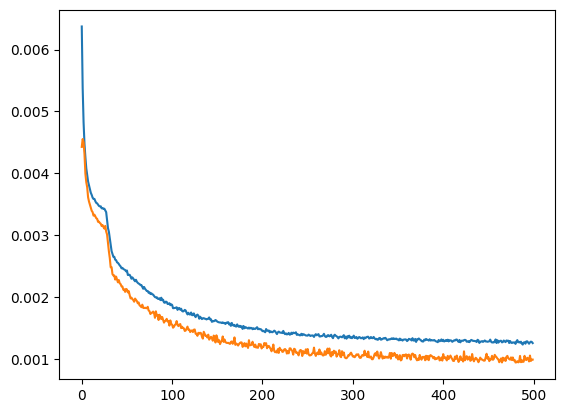

In [8]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])


In [9]:
model.load_state_dict(best_weights)
torch.save(best_weights,'../trained_weights/SISR_denoise%d.pt'%(int(NOISE_STD*10)))

/tmp/ipykernel_1506192/3935533979.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t1 = torch.tensor(LR.view(1,1,64,64))


Text(0.5, 1.0, 'Train_Ground truth')

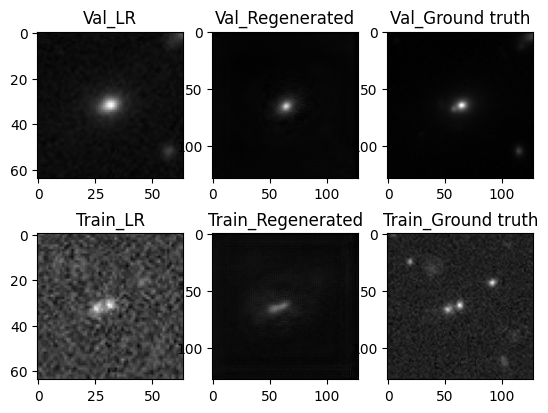

In [10]:
pre, post, tHR = show_random_image(val_dataset, model, 30)
pret, postt, tHRt = show_random_image(train_dataset, model, 270)
plot, axes = plt.subplots(2,3)
axes[0][0].imshow(pre)
axes[0][1].imshow(post)
axes[0][2].imshow(tHR)
axes[0][0].set_title("Val_LR")
axes[0][1].set_title("Val_Regenerated")
axes[0][2].set_title("Val_Ground truth")

axes[1][0].imshow(pret)
axes[1][1].imshow(postt)
axes[1][2].imshow(tHRt)
axes[1][0].set_title("Train_LR")
axes[1][1].set_title("Train_Regenerated")
axes[1][2].set_title("Train_Ground truth")

In [11]:
# plot, axes = plt.subplots(len(images),3)
# plot.set_size_inches(30,len(images)*10)
# for i in range(len(images)):
#     axes[i][0].imshow(images[i][0])
#     axes[i][1].imshow(images[i][1])
#     axes[i][2].imshow(images[i][2])